In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from time import time
from tqdm import tqdm as tqdm
import pcmdpy_gpu as ppy
%matplotlib inline

In [2]:
ppy.__version__

'0.8.5'

In [3]:
mpl.style.use('seaborn-poster')

In [4]:
f = ppy.instrument.default_m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv_cpu = ppy.driver.Driver(iso_model, gpu=False)
driv_gpu = ppy.driver.Driver(iso_model, max_Nim=4096, gpu=True)

Please wait while the GPU states are initialized

In [5]:
gals = {}
gals['ssp'] = ppy.galaxy.SSPSimple(np.array([0., -2., 2.0, 10.]), dmod=26.0)
gals['tau'] = ppy.galaxy.CustomGalaxy(
    'single',
    'single',
    'tau',
    'variable',
    initial_params=np.array([0., -2.0, 2.0, 3.0, 26.0])
)
gals['taumdf'] = ppy.galaxy.TauFull(np.array([0., -2.0, 2.0, 3.0, 26.0]))

In [6]:
%%time
imf_taumdf, _ = iso_model.model_galaxy(gals['taumdf'], downsample=5)

CPU times: user 2.46 s, sys: 65.6 ms, total: 2.52 s
Wall time: 2.52 s


In [7]:
len(imf_taumdf)

28497

In [8]:
N_cpu = [128, 256, 512, 1024]
N_gpu = [128, 256, 512, 1024, 2048, 4096]

In [9]:
def time_sim(gal, Nim, psf, gpu, n_sample=5, max_time_sample=10., downsample=5, **kwargs):
    times = []
    if gpu:
        driv = driv_gpu
        # get GPU warmed up
        _ = driv_gpu.simulate(gal, 128, psf=False, downsample=10)
    else:
        driv = driv_cpu
    for i in range(n_sample):
        t_start = time()
        _ = driv.simulate(gal, Nim, downsample=downsample, psf=psf, fixed_seed=True, shot_noise=False, sky_noise=None, **kwargs)
        times.append(time() - t_start)
        if times[-1] > max_time_sample:
            break
    return np.median(times), times

In [10]:
def get_times(key):
    gpu_str, gal_str, psf_str = key.split('_')
    gpu = (gpu_str == 'gpu')
    if not gpu: assert gpu_str == 'nogpu'
    if gpu:
        Nims = Nims_gpu
    else:
        Nims = Nims_cpu
    psf = (psf_str == 'psf')
    if not psf: assert psf_str == 'nopsf'
    return np.array([time_sim(gals[gal_str], Nim, psf=psf, gpu=gpu)[0] for Nim in tqdm(Nims, desc=key, leave=False)])

# GPU Speedup

In [11]:
t_cpu = []
for N in tqdm(N_cpu):
    t_cpu.append(time_sim(gals['ssp'], N, psf=True, gpu=False, n_sample=10, downsample=5)[0])

100%|██████████| 4/4 [01:52<00:00, 27.60s/it]


In [12]:
t_gpu = []
for N in tqdm(N_gpu):
    t_gpu.append(time_sim(gals['ssp'], N, psf=True, gpu=True, n_sample=10, downsample=5, max_time_sample=10.)[0])

100%|██████████| 6/6 [01:32<00:00, 19.55s/it]


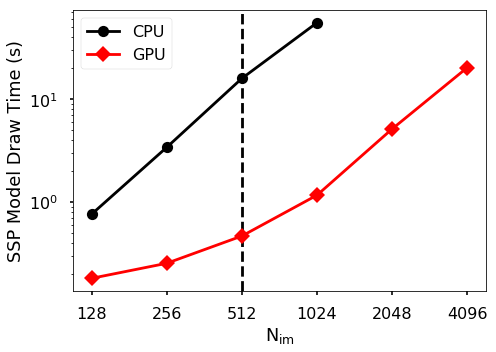

In [26]:
fig, axis = plt.subplots(figsize=(7,5))
axis.plot(N_cpu, t_cpu, 'ko-', label='CPU')
axis.plot(N_gpu, t_gpu, 'rD-', label='GPU')
# axis.plot(N_gpu[2], t_gpu[2], 'rD-', mfc='w', mew=3)
# axis.plot(N_cpu[2], t_cpu[2], 'ko-', mfc='w', mew=3)
# axis.plot(N_gpu, t_gpu_tau, 'rD--', label='GPU (Tau Model)', mfc='w', mew=3)
# axis.plot(N_gpu, t_gpu_taumdf, 'rs:', label='GPU (Tau MDF Model)', mfc='w', mew=3)
# axis.plot(N_cpu, t_cpu[-1] * (np.array(N_cpu) / N_cpu[-1])**2, 'k--')
# axis.plot(N_gpu, t_gpu[-1] * (np.array(N_gpu) / N_gpu[-1])**2, 'r--')
axis.axvline(x=512, ls='--', color='k', zorder=-1)
axis.set_xscale('log')
axis.set_xticks([128, 256, 512, 1024, 2048, 4096])
axis.set_xticks([], minor=True)
axis.set_xticklabels([128, 256, 512, 1024, 2048, 4096])
axis.set_yscale('log')

# axis.set_ylim(ymin=3e-1)

axis.legend(loc=0)
axis.set_xlabel(r'$\mathrm{N_{im}}$')
axis.set_ylabel('SSP Model Draw Time (s)')
plt.tight_layout()
plt.savefig('figures/paper1/gpu_speedup.pdf')

In [24]:
np.array(t_cpu) / np.array(t_gpu[:-2])

array([ 4.20630733, 13.45348712, 34.21922692, 47.76036932])

In [25]:
!nvidia-smi

Thu Jan 24 16:37:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40m          Off  | 00000000:42:00.0 Off |                    0 |
| N/A   47C    P0    61W / 235W |   1774MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [27]:
t_gpu_tau = []
for N in tqdm(N_gpu):
    t_gpu_tau.append(time_sim(gals['tau'], N, psf=True, gpu=True, n_sample=10, downsample=5, max_time_sample=10.)[0])

100%|██████████| 6/6 [02:47<00:00, 35.92s/it]


In [28]:
t_gpu_taumdf = []
for N in tqdm(N_gpu):
    t_gpu_taumdf.append(time_sim(gals['taumdf'], N, psf=True, gpu=True, n_sample=10, downsample=5, max_time_sample=10.)[0])

100%|██████████| 6/6 [05:14<00:00, 66.41s/it]


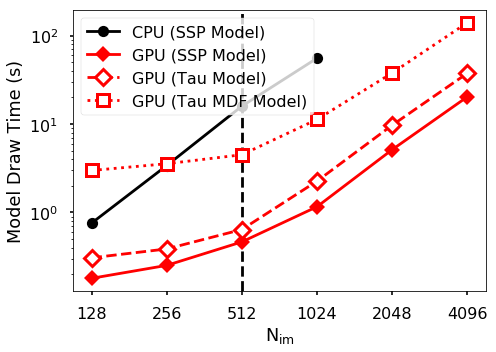

In [29]:
fig, axis = plt.subplots(figsize=(7,5))
axis.plot(N_cpu, t_cpu, 'ko-', label='CPU (SSP Model)')
axis.plot(N_gpu, t_gpu, 'rD-', label='GPU (SSP Model)')
axis.plot(N_gpu, t_gpu_tau, 'rD--', label='GPU (Tau Model)', mfc='w', mew=3)
axis.plot(N_gpu, t_gpu_taumdf, 'rs:', label='GPU (Tau MDF Model)', mfc='w', mew=3)
axis.axvline(x=512, ls='--', color='k', zorder=-1)
axis.set_xscale('log')
axis.set_xticks([128, 256, 512, 1024, 2048, 4096])
axis.set_xticks([], minor=True)
axis.set_xticklabels([128, 256, 512, 1024, 2048, 4096])
axis.set_yscale('log')

# axis.set_ylim(ymin=3e-1)

axis.legend(loc=0)
axis.set_xlabel(r'$\mathrm{N_{im}}$')
axis.set_ylabel('Model Draw Time (s)')
plt.tight_layout()
plt.savefig('figures/paper1/gpu_speedup_all.pdf')

# GPU Scaling

In [16]:
imf_, mags_ = iso_model.model_galaxy(gals['taumdf'], downsample=1)

In [17]:
imf = np.tile(imf_, 10)
mags = np.tile(mags_, 10)

In [18]:
fluxes = np.array([filt.mag_to_counts(m) for filt,m in zip(f, mags)])

In [19]:
def draw(Niso, Nim=1024, gpu=True, psf=True):
    imf_temp = imf[:Niso]
    fluxes_temp = fluxes[:, :Niso]
    dust_frac, dust_mean, dust_std = gals['taumdf'].dust_model.get_props()
    images = ppy.gpu_utils.draw_image(imf_temp, fluxes_temp, Nim, f, dust_frac, dust_mean, dust_std, gpu=gpu, fixed_seed=False)
    if psf:
        images = np.array([filt.psf_convolve(im) for filt,im in zip(f, images)])
    images += 1e-3
    mags = np.array([filt.counts_to_mag(im.flatten()) for filt,im in zip(f, images)])
    pcmd = ppy.utils.make_pcmd(mags)
    return pcmd

In [20]:
def time_draw(Niso, Nim=1024, gpu=True, psf=True, n_sample=5, t_max=10.):
    times = []
    if gpu:
        # get GPU warmed up
        _ = driv_gpu.simulate(gals['ssp'], 128, psf=False, downsample=10)
    for i in range(n_sample):
        t_start = time()
        _ = draw(Niso, Nim=Nim, gpu=gpu, psf=psf)
        times.append(time() - t_start)
        if times[-1] > t_max:
            break
    return np.median(times)

In [21]:
time_draw(1000, Nim=512)

TypeError: _draw_image_gpu() missing 1 required positional argument: 'd_states'

In [ ]:
Niso = [1000, 3000, 10000, 30000, 100000, 300000, 1000000]

In [ ]:
t_128 = [time_draw(N, Nim=128) for N in tqdm(Niso)]

In [ ]:
t_512 = [time_draw(N, Nim=512) for N in tqdm(Niso)]

In [ ]:
t_1024 = [time_draw(N, Nim=1024) for N in tqdm(Niso)]

In [ ]:
t_128

In [ ]:
t_512

In [ ]:
t_1024

In [ ]:
fig, axis = plt.subplots(figsize=(7,5))
axis.plot(Niso, t_128, 'ko-', label=r'$\mathrm{N_{im}}$=128')
axis.plot(Niso, t_512, 'rD-', label=r'$\mathrm{N_{im}}$=512', mfc='w', mew=3)
axis.plot(Niso, t_1024, 'bs-', label=r'$\mathrm{N_{im}}$=1024', mfc='w', mew=3)

axis.set_xlabel(r'$\mathrm{N_{iso}}$')
axis.set_ylabel('Simulation Time (s)')
axis.set_xscale('log')
axis.set_yscale('log')
axis.legend(loc=0)
plt.savefig('figures/paper1/gpu_scaling.pdf')